<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/05_Advanced_RAG_Query_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): Query Expansion
This Notebook implements an advanced RAG system with Query Expansion technique to enhance document retrieval in RAG-based applications.

## Pre requisites

In [ ]:
!pip install -r rag_requirements.txt

## Imports

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [ ]:
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

llm_gpt4_turbo = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

## Use this if using open ai embeddings the Azure way
# EMBEDDING_API_KEY = os.getenv('API_KEY')
# EMBEDDING_API_BASE = os.getenv('API_BASE')
# EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

# embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
#                               openai_api_key=EMBEDDING_API_KEY,
#                               openai_api_base=EMBEDDING_API_BASE,
#                               openai_api_version=API_VERSION,
#                               openai_api_type=API_TYPE,
#                               chunk_size=1)

## Query Expansion

Query expansion refers to a set of techniques that rephrase the original query. Two popular methods that are easy to implement will be discussed in this notebook.

#### Technique 1 - Query expansion with a generated answer
Given an input query, this method first instructs an LLM to provide a hypothetical answer, whatever its correctness. Then, the query and the generated answer are combined in a prompt and sent to the retrieval system.


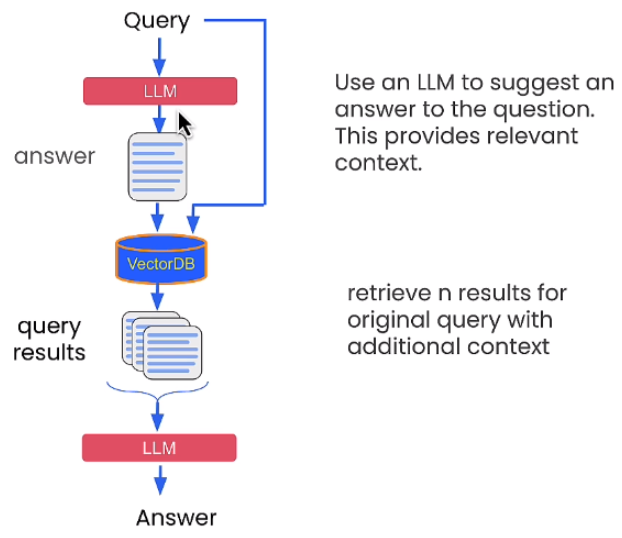

For a change we use an open source embedding model names Sentence Transformer (356 dimensionality)

In [ ]:
from utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
chroma_collection = load_chroma(filename='/content/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

Now let's make a function to generate a ficticious or hypothetical answer from an annual report for a given query

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser

def augment_query_generated(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report.
            Question: {question}""")
        | llm_gpt4_turbo | StrOutputParser()
    )
    return chain.invoke({'question':query})

Now we try to generate a hypothetical answer for a query and concatenate the two

In [ ]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Example
Answer:

During the fiscal year 2022, we experienced a moderate level
of turnover within our executive team. We saw the departure of two key
executives: our Chief Financial Officer, Jane Doe, who retired after a
distinguished 10-year tenure with the company, and our Chief Technology
Officer, John Smith, who left to pursue an opportunity at another
firm.

To ensure a smooth transition and maintain our strategic
momentum, we promptly filled these vacancies with highly qualified
successors. Emily Johnson, who has been with our company for over 15
years and served as Deputy CFO, was promoted to the role of Chief
Financial Officer. Her deep understanding of our financial operations
and strategic vision made her the ideal candidate to lead our financial
team.

For the Chief Technology Officer position, we conducted an
extensive search and recruited Michael Brown, a seasoned technology
leader with over 20 years of experience in the

Now we got a joint query which is a combination of thr original query and the hypothetical answer (generated by LLM)

Let' try to get top 5 documents from chroma collections which are close to the join query

In [ ]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

# Print the retrieved documents
for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

89 directors and executive officers of microsoft corporation directors
satya nadella chairman and chief executive officer, microsoft
corporation sandra e. peterson 2, 3 operating partner, clayton,
dubilier & rice, llc john w. stanton 1, 4 founder and chairman, trilogy
partnerships reid g. hoffman 4 general partner, greylock partners penny
s. pritzker 4 founder and chairman, psp partners, llc john w. thompson
3, 4 lead independent director, microsoft corporation hugh f. johnston
1 vice chairman and executive vice president and chief financial
officer, pepsico, inc. carlos a. rodriguez 1 chief executive officer,
adp, inc. emma n. walmsley 2, 4 chief executive officer, gsk, plc teri
l. list 1, 3 former executive vice president and chief financial
officer, gap, inc. charles w. scharf 2, 3 chief executive officer and
president, wells fargo & company padmasree warrior 2 founder, president
and chief executive

officer, fable group inc. board committees 1. audit committee 2.
compensation commi

In [ ]:
import umap

# get the embeddings from the chroma collections
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

# Perform umap fit on the high dimensional embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [07:22<00:00,  1.27s/it]


In [ ]:
# Number of docs retrieved
len(results['embeddings'][0])

5

In [ ]:
# Embedding vector length of each doc retrieved
len(results['embeddings'][0][0])

384

In [ ]:
# get the embedding vectors for all the retrieved documents from the results obj.
retrieved_embeddings = results['embeddings'][0]

# Get the embedding for the original and the joint query
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

# Get the 2D umap fit of the original query
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)

# Get the 2D umap fit of joint query
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)

# Get the 2D umap fit of the docs retrived using the joint query
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


### Plot the projected query and retrieved documents in the embedding space

(-4.539441323280334, 6.32378933429718, 4.321742844581604, 9.370773959159852)

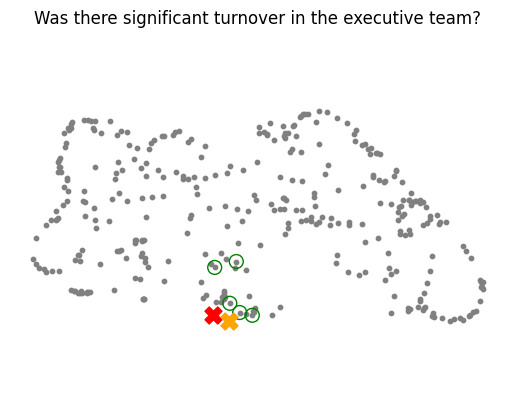

In [ ]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

#### Technique 2 - Query expansion with multiple queries
Given an input query, this method instructs an LLM to generate N questions related to the original query and then sends them all (+ the original query) to the retrieval system.

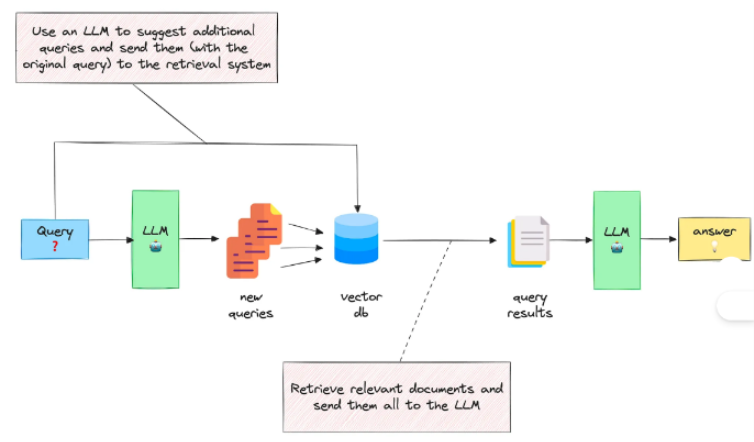

Make multiple queries for the original query using an LLM

In [ ]:
def augment_multiple_query(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Your users are asking questions about an annual report.
            Suggest up to five additional related questions to help them find the information they need, for the provided question.
            Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.
            Make sure they are complete questions, and that they are related to the original question.
            Output one question per line
            Quesion: {question}""")
        | llm_gpt4_turbo
        | StrOutputParser()
    )
    return chain.invoke({'question':query})

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)
augmented_queries = augmented_queries.split('\n')

for query in augmented_queries:
    print(query)

What new products or services were launched last year?
How did market expansion impact revenue growth?
Were there any significant changes in pricing strategy?
What was the impact of currency fluctuations on revenue?
How did customer acquisition trends affect revenue?


In [ ]:
# Combine original and augmented queries
queries = [original_query] + augmented_queries
queries

['What were the most important factors that contributed to increases in revenue?',
 'What new products or services were launched last year?',
 'How did market expansion impact revenue growth?',
 'Were there any significant changes in pricing strategy?',
 'What was the impact of currency fluctuations on revenue?',
 'How did customer acquisition trends affect revenue?']

In [ ]:
# Get the 5 docs which are pretty close to each query in the queries list
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])


In [ ]:
len(results['documents'][0])

5

In [ ]:
retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [ ]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


In [ ]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


(-4.539441323280334, 6.32378933429718, 4.321742844581604, 9.370773959159852)

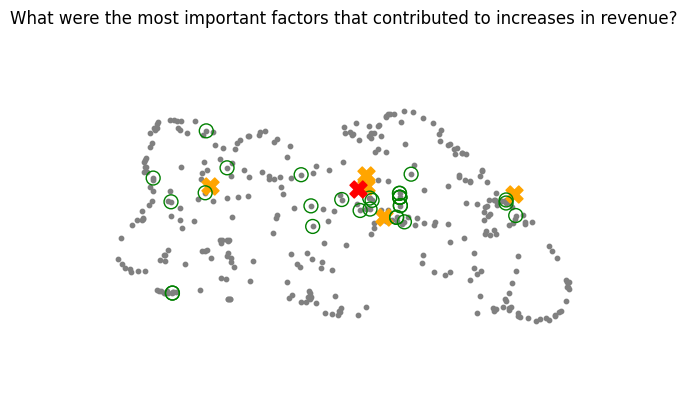

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Try to include cross encoder based reranking to the retrived documents

## Query Expansion with cross encoder Re ranking

Cross encoding is a combination of multiple queries and cross encoder re ranking, as user able to generate more questions using LLM, each generated query will able to extract couple of documents from vector database.

Those extracted documents must be passed through a cross-encoder to obtain similarity scores with the initial query. Now we can re ranking does relevant document and pick top 5 to be used as context of our LLM summarization.

Why we need to pick the top 5 documents? In this case we try to avoid the irrelevant documents that we retrieved from vector database. This selection ensures that the cross-encoder focuses on the most similar and meaningful documents, thereby generating a more accurate and concise summary.


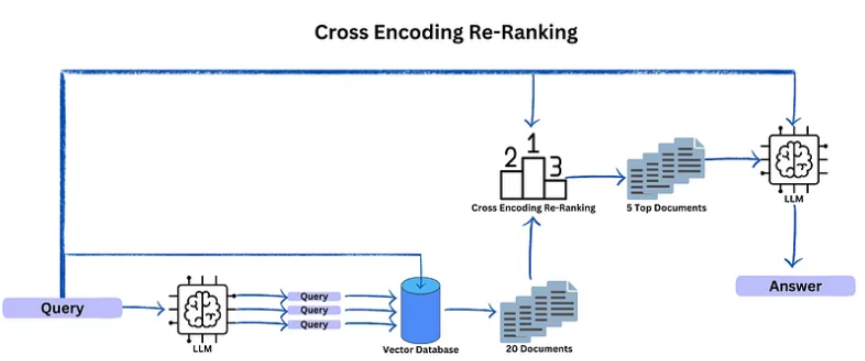

In [ ]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

#Cross Encoding happens in here
def create_documents(queries, retrieved_documents):

    retrieved_documents = [element for sublist in retrieved_documents for element in sublist]
    unique_a = []
    #If there is duplication documents for each query, make it unique
    for item in retrieved_documents:
        if item not in unique_a:
            unique_a.append(item)

    unique_documents = list(unique_a)

    pairs = []
    for doc in unique_documents:
        pairs.append([queries[0], doc])

    #Cross Encoder Scoring
    scores = cross_encoder.predict(pairs)

    final_queries = []
    for x in range(len(scores)):
        final_queries.append({"score":scores[x],"document":unique_documents[x]})

    #Rerank the documents, return top 5
    sorted_list = sorted(final_queries, key=lambda x: x["score"], reverse=True)
    first_five_elements = sorted_list[:6]
    return first_five_elements

In [ ]:
create_documents(augmented_queries, retrieved_documents)